In [1]:
%matplotlib inline

In [2]:
#@title
import jax
import numpy as np

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

try:
  import flax
except ModuleNotFoundError:
  !pip install --quiet flax==0.6.4
  import flax

try:
  import optax
except ModuleNotFoundError:
  !pip install --quiet optax
  import optax

from flax import linen as nn
from flax.training import train_state

from tqdm import trange
from functools import partial
from matplotlib import pyplot as plt

# Diffusion models

## Intro
We define the forward time SDE
$$dx_t = dtf_t(x_t) + g_tdW_t\,,$$
which defines a map from the data distribution to the normal density.

After training, we can simulate the reverse process (generate data) via the following SDE
$$dx_\tau = d\tau(-f_{1-\tau}(x_\tau) + (\frac{g_{1-\tau}^2}{2}+\xi_\tau)\nabla\log q_{1-\tau}(x_\tau)) + \sqrt{2\xi_\tau}d\bar{W}_\tau\,,$$
which becomes an ODE for $\xi_\tau \equiv 0$.

Let's define the noising SDE as the OU process, i.e. for every object in our data distribution $\mu^i \sim p_{\text{data}}(\mu)$, the noising process is
$$q_t^i(x) = \mathcal{N}(x|\alpha_t\mu^i,\sigma_t^2)\,.$$
The important part about defining this process is that we know the vector field satisfying the corresponding continuity equation
$$v_t^i(x) = (x-\alpha_t\mu^i)\frac{\partial}{\partial t}\log\sigma_t + \frac{\partial\alpha_t}{\partial t}\mu^i\,.$$
For the entire dataset we can write down the following marginal density
$$q_t(x) = \int \mathcal{N}(x|\alpha_t\mu,\sigma_t^2)p_{\text{data}}(\mu)d\mu\,,$$
and we can write down the loss for the vector field as
$$\text{Loss} = \frac{1}{N}\sum_{i=1}^N\int dt\;\int dx\;\Vert v_t(x;\theta) - v_t^i(x)\Vert^2\,,$$
where $\theta$ are the parameters of our model.

In terms of the SDE, we have
$$f_t(x) = x\frac{\partial}{\partial t}\log\alpha_t\,,\;\;\; g_t = \sqrt{2\sigma_t^2\frac{\partial}{\partial t}\log \frac{\sigma_t}{\alpha_t}}\,.$$

## Data Generation

$p_{\text{data}}(\mu)$ is just a mixture of four Gaussians. Then we define the noising process
$$q_t^i(x) = \mathcal{N}(x|\alpha_t\mu^i,\sigma_t^2)\,.$$
See code for $\alpha_t, \sigma_t$.
The plots represent samples from the following marginals for different times $t$
$$q_t(x) = \int \mathcal{N}(x|\alpha_t\mu,\sigma_t^2)p_{\text{data}}(\mu)d\mu\,.$$

In [3]:
from typing import NamedTuple, Any

def sample_data(key, bs):
  keys = random.split(key, 3)
  x_1 = random.randint(keys[0], minval=0, maxval=2, shape=(bs, 2))
  x_1 = 3*(x_1.astype(jnp.float32)-0.5)
  x_1 += 4e-1*random.normal(keys[1], shape=(bs,2))
  return x_1

t_0, t_1 = 0.0, 1.0
beta_0 = 0.1
beta_1 = 20.0
log_alpha = lambda t: -0.5*t*beta_0-0.25*t**2*(beta_1-beta_0)
# log_sigma = lambda t: jnp.log(jnp.sqrt(-jnp.expm1(-t*beta_0-0.5*t**2*(beta_1-beta_0))))
log_sigma = lambda t: jnp.log(t)
dlog_alphadt = jax.grad(lambda t: log_alpha(t).sum())
dlog_sigmadt = jax.grad(lambda t: log_sigma(t).sum())
# gamma_t = s_t d/dt log(s_t/alpha_t)
# gamma = lambda t: jnp.exp(log_sigma(t))*(dlog_sigmadt(t) - dlog_alphadt(t))
gamma = lambda t: (1 + 0.5*t*beta_0 + 0.5*t**2*(beta_1-beta_0))

def q_t(key, data, t):
  eps = random.normal(key, shape=data.shape)
  x_t = jnp.exp(log_alpha(t))*data + jnp.exp(log_sigma(t))*eps
  return eps, x_t

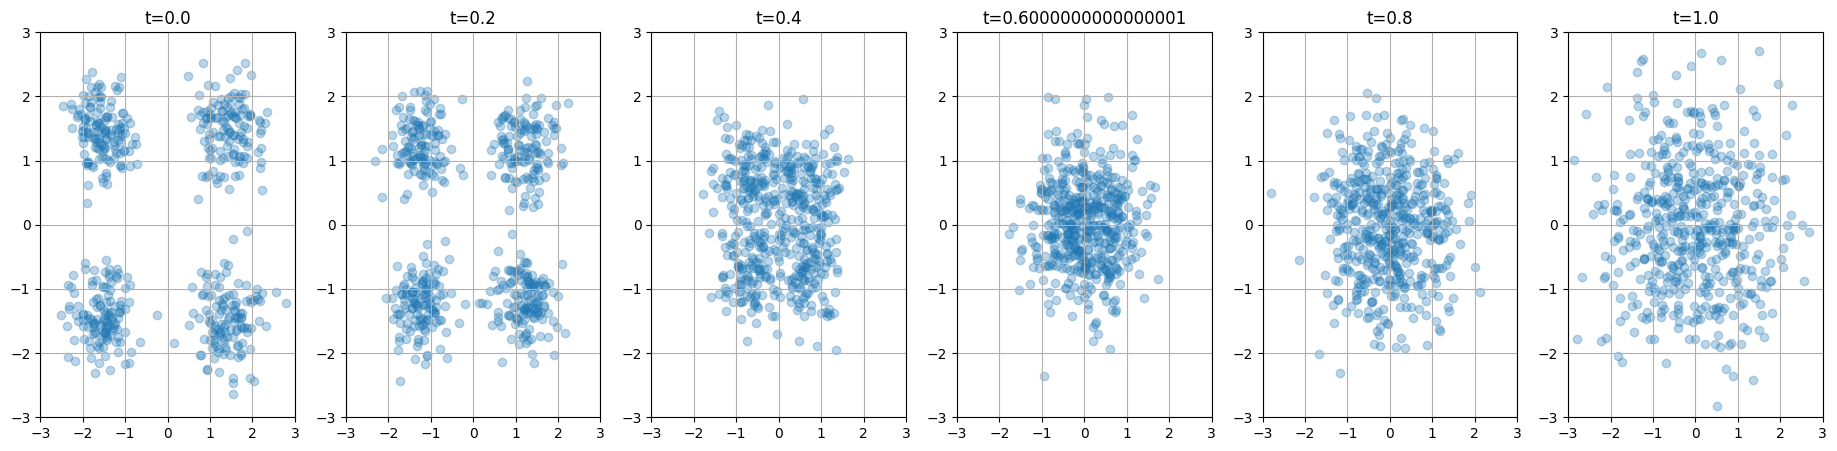

In [4]:
seed = 0
np.random.seed(seed)
key = random.PRNGKey(seed)
bs = 512
t_axis = np.linspace(0.0, 1.0, 6)

plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs), t_axis[i])
  plt.scatter(x_t[:,0], x_t[:,1], alpha=0.3)
  plt.title(f't={t_axis[i]}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()

## Define the Model

For the model of the vector field $v_t(x;\theta)$, we take an MLP.

In [5]:
class MLP(nn.Module):
  num_hid : int
  num_out : int

  @nn.compact
  def __call__(self, t, x):
    h = jnp.hstack([t,x])
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.relu(h)
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(features=self.num_out)(h)
    return h

In [6]:
model = MLP(num_hid=512, num_out=x_t.shape[1])
print(model)

key, init_key = random.split(key)
optimizer = optax.adam(learning_rate=2e-4)
state = train_state.TrainState.create(apply_fn=model.apply,
                                      params=model.init(init_key, np.ones([bs,1]), x_t),
                                      tx=optimizer)

MLP(
    # attributes
    num_hid = 512
    num_out = 2
)


## Loss Function

In general, the loss looks like this
$$\text{Loss} = \frac{1}{N}\sum_{i=1}^N\int dt\;\int dx\;\Vert v_t(x;\theta) - v_t^i(x)\Vert^2\,.$$
However, we rewrite it a bit in terms of the score and parametrize the following quantity
$$\text{MLP}(t,x;\theta) = \sigma_t\nabla_x\log q_t(x)\,.$$

In [7]:
def sm_loss(state, key, params, bs):
  keys = random.split(key, )
  sdlogqdx = lambda _t, _x: state.apply_fn(params, _t, _x)
  data = sample_data(keys[0], bs)
  t = random.uniform(keys[1], [bs,1])
  eps, x_t = q_t(keys[2], data, t)
  loss = ((eps + sdlogqdx(t, x_t))**2).sum(1)
  print(loss.shape, 'final.shape', flush=True)
  return loss.mean()

@partial(jax.jit, static_argnums=1)
def train_step(state, bs, key):
  grad_fn = jax.value_and_grad(sm_loss, argnums=2)
  loss, grads = grad_fn(state, key, state.params, bs)
  state = state.apply_gradients(grads=grads)
  return state, loss

key, loc_key = random.split(key)
state, loss = train_step(state, bs, loc_key)

(512,) final.shape


## Train Loop

In [8]:
num_iterations = 20_000

loss_plot = np.zeros(num_iterations)
key, loop_key = random.split(key)
for iter in trange(num_iterations):
  state, loss = train_step(state, bs, random.fold_in(loop_key, iter))
  loss_plot[iter] = loss

100%|██████████| 20000/20000 [00:23<00:00, 837.72it/s]


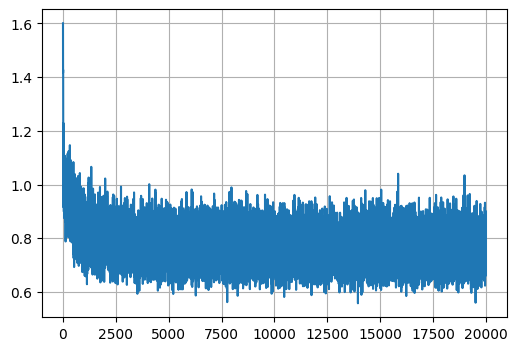

In [9]:
plt.figure(figsize=(6,4))
plt.plot(loss_plot)
plt.grid()

## Evaluation of the Trained Model

$$dx_\tau = d\tau(-f_{1-\tau}(x_\tau) + (\frac{g_{1-\tau}^2}{2}+\xi_\tau)\nabla\log q_{1-\tau}(x_\tau)) + \sqrt{2\xi_\tau}d\bar{W}_\tau\,,$$
$$f_t(x) = x\frac{\partial}{\partial t}\log\alpha_t\,,\;\;\; g_t = \sqrt{2\sigma_t^2\frac{\partial}{\partial t}\log \frac{\sigma_t}{\alpha_t}}\,\;\;\; \gamma_t = \sigma_t\frac{\partial}{\partial t}\log \frac{\sigma_t}{\alpha_t}.$$

In [10]:
# v_t(x) = -dlog(alpha)/dt x + s^2_t d/dt log(s_t/alpha_t) dlog q_t(x)/dx
@jax.jit
def vector_field(t,x,xi=0.0):
  sdlogqdx = lambda _t, _x: state.apply_fn(state.params, _t, _x)
  dxdt = -dlog_alphadt(t)*x + gamma(t)*sdlogqdx(t, x) + xi*gamma(t)*sdlogqdx(t, x)
  return dxdt

In [11]:
dt = 1e-2
xi = 1.0
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
key, ikey = random.split(key, num=2)
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, x_t.shape[1])))
for i in trange(n):
  key, ikey = random.split(key, num=2)
  dx = dt*vector_field(t, x_gen[:,i,:], xi) + jnp.sqrt(2*xi*gamma(t)*jnp.exp(log_sigma(t))*dt)*random.normal(ikey, shape=(bs,2))
  x_gen = x_gen.at[:,i+1,:].set(x_gen[:,i,:] + dx)
  t += -dt

100%|██████████| 100/100 [00:01<00:00, 99.60it/s] 


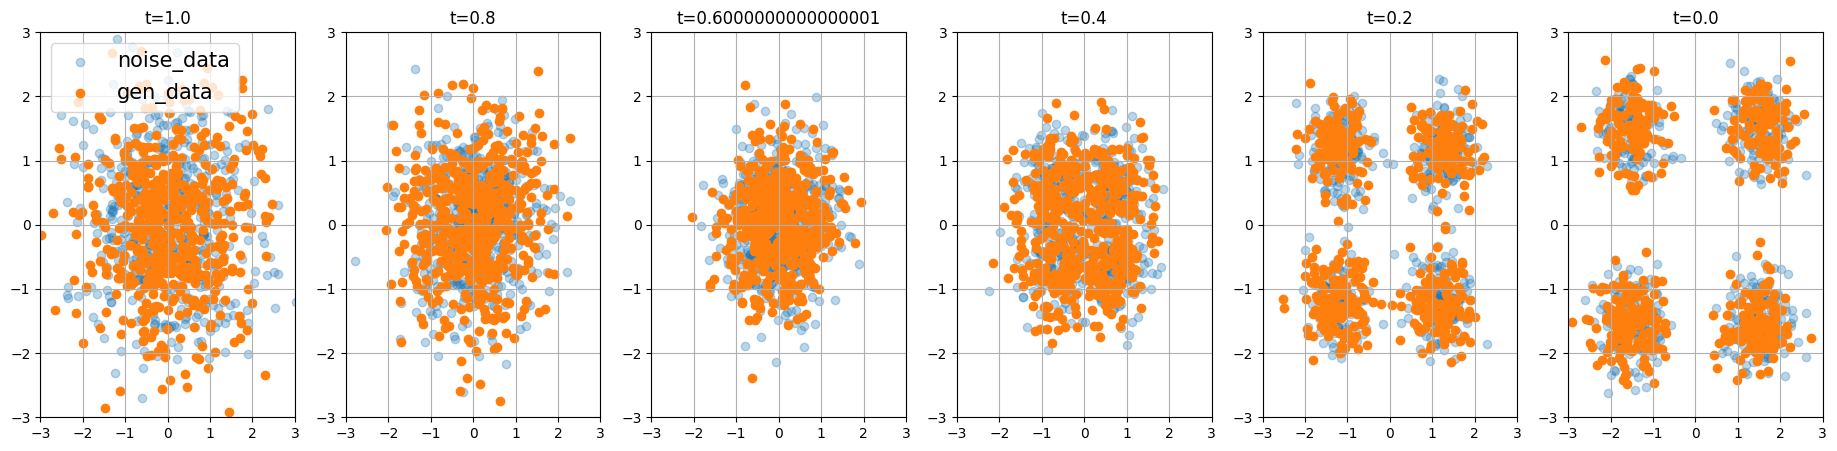

In [12]:
plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data', alpha=0.3)
  plt.scatter(x_gen[:,int(n*(t_axis[i])),0], x_gen[:,int(n*(t_axis[i])),1], label='gen_data')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)

## Annealing

Let's use the following estimator
$$dx_\tau = d\tau(-f_{1-\tau}(x_\tau) + \beta g_{1-\tau}^2\nabla\log q_{1-\tau}(x_\tau)) + g_{1-\tau}d\bar{W}_\tau\,,$$
$$dw_\tau = (\beta-1)\langle \nabla, f_{1-\tau}\rangle + \frac{1}{2}g_{1-\tau}^2(\beta-1)\beta\Vert\nabla \log q_{1-\tau}\Vert^2$$
where $\beta$ is the inverse temperature

# *** RESAMPLING CODE **

In [13]:
# def sample_uniform(bs, start, u0=0.0, u1=1.0):
#     u = (start + jnp.sqrt(2)*jnp.arange(bs*jax.device_count()+1)) % 1
#     start=u[-1]
#     u = (u1-u0)*u[jax.process_index()*bs:(jax.process_index()+1)*bs] + u0
#     return u, start

from scipy.stats import qmc
sampler = qmc.Sobol(d=1, scramble=False)

def sample_cat(bs, next_u, logits):
    # u, next_u = sample_uniform(bs, next_u)
    u = sampler.random(bs).squeeze()
    bins = jnp.cumsum(nn.softmax(logits))
    ids = jnp.digitize(u, bins)
    return ids, next_u

@partial(jax.jit, static_argnums=0)
def sample_cat_sys(bs, key, logits):
    u = jax.random.uniform(key, shape=(1,))
    u = (u + 1/bs*jnp.arange(bs)) % 1
    bins = jnp.cumsum(nn.softmax(logits))
    ids = jnp.digitize(u, bins)
    return ids, None


@partial(jax.jit, static_argnums=[0,5])
def sample_birth_death_clocks(bs, key, accum_birth, accum_death, thresh_times, reset_transition_per_index=True):
    
    key, *keys = random.split(key, num=3)

    death_mask = (accum_death >= thresh_times)
    
    ids = jnp.arange(bs)
    
    ''' sample candidate replacement indices according to *accumulated* birth weights (justified?  works well tho)''' 
    if reset_transition_per_index:
        transition_probs = accum_birth/jnp.sum(accum_birth, axis=-1, keepdims=True)
        subkeys = jax.random.split(keys[0], transition_probs.shape[0])
        replace_ids = jax.vmap(lambda _key, p: jax.random.choice(_key, ids, p=p))(subkeys, transition_probs)
    else:
        transition_probs = accum_birth/jnp.sum(accum_birth)
        replace_ids = jax.random.choice(keys[0], ids,  shape=(bs,), p = transition_probs , replace=True)

    ''' replace those entries chosen for killing ''' 
    ids = jnp.where(death_mask, replace_ids, ids)
        
    ''' sample new jump thresholds'''
    new_thresh_times = random.exponential(keys[1], shape=(bs,)) 
        
    thresh_times = jnp.where(death_mask, new_thresh_times, thresh_times)

    ''' reset birth and death weights in killed indices '''
    if reset_transition_per_index:
        accum_birth = jnp.where(death_mask.reshape(-1,1), jnp.zeros_like(accum_birth), accum_birth)
    else:
        accum_birth = jnp.where(death_mask, jnp.zeros_like(accum_birth), accum_birth)

    accum_death = jnp.where(death_mask, jnp.zeros_like(accum_death), accum_death)
    
    metrics = (jnp.sum(death_mask),)
    return ids, accum_birth, accum_death, thresh_times, metrics

In [41]:
@jax.jit
def sdlogqdx_fn(t,x):
  return state.apply_fn(state.params, t, x)

''' HYPERPARAMS ''' 
resample = 'birth_death_clock'
reset_transition_per_index = True

scale_noise= True


inv_temp = 10
next_u = 0.5
dt = 1e-3
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
key, ikey = random.split(key, num=2)
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, x_t.shape[1]))/jnp.sqrt(inv_temp))
w_gen = jnp.zeros((bs,n+1,1))


''' NEW SETUP '''
if resample == 'birth_death_clock':
    if reset_transition_per_index:
      accum_birth = jnp.zeros((w_gen.shape[0], bs))
    else:
      accum_birth = jnp.zeros(w_gen.shape[0])

    accum_death = jnp.zeros(w_gen.shape[0])
    key, ikey = random.split(key, num=2)
    clock_thresholds = random.exponential(ikey, shape=(bs,))
    
    
for i in trange(n):
  key, *ikey = random.split(key, num=3)
  sdlogqdx = sdlogqdx_fn(t, x_gen[:,i,:])
  
  if not scale_noise:
    dx = dt*(-dlog_alphadt(t)*x_gen[:,i,:] + 2*inv_temp*gamma(t)*sdlogqdx) + jnp.sqrt(2*gamma(t)*jnp.exp(log_sigma(t))*dt)*random.normal(ikey[0], shape=(bs,2))
  else:
    dx = dt*(-dlog_alphadt(t)*x_gen[:,i,:] + (gamma(t)+inv_temp*gamma(t))*sdlogqdx) + jnp.sqrt(2*gamma(t)/inv_temp*jnp.exp(log_sigma(t))*dt)*random.normal(ikey[0], shape=(bs,2))
  x_gen = x_gen.at[:,i+1,:].set(x_gen[:,i,:] + dx)
  
  dw = dt*((inv_temp-1)*2*dlog_alphadt(t) + 0.5*(inv_temp-1)*inv_temp*((jnp.sqrt(2*gamma(t)/jnp.exp(log_sigma(t)))*sdlogqdx)**2).sum(1, keepdims=True))
  w_gen = w_gen.at[:,i+1,:].set(w_gen[:,i,:] + dw)

  
  if resample == 'birth_death_clock':
    ''' note, dw is correctly scaled by dt'''
    dw = dw[:,0] # spurious extra dim
    avg = jnp.mean(dw, axis=0, keepdims=True)
    
    ''' accumulate thresholded weight increments (only sizing differences)'''
    accum_death = accum_death + jnp.where(dw-avg<0, avg-dw, jnp.zeros_like(dw))
    if reset_transition_per_index:
      bw_inc = jnp.where(dw-avg>0, dw-avg, jnp.zeros_like(dw))
      accum_birth = accum_birth + bw_inc[:,None]
    else:
      accum_birth = accum_birth + jnp.where(dw-avg>0, dw-avg, jnp.zeros_like(dw))
      
    
    ''' sampler resets accum_birth/death, clock_thresholds where necessary '''
    new_ids, accum_birth, accum_death, clock_thresholds, metrics \
      = sample_birth_death_clocks(bs, ikey[1], accum_birth, accum_death, clock_thresholds, reset_transition_per_index)
    
    x_gen = x_gen.at[:,i+1,:].set(x_gen[new_ids,i+1,:])
    
    
    ''' resetting the weights has no effect here '''
    w_gen = w_gen.at[:,i+1,:].set(0)
    
  elif resample == 'systematic':
    # new_ids = jax.random.choice(ikey[1], bs, (bs,), p=nn.softmax(w_gen[:,i+1,0]))
    # new_ids, next_u = sample_cat(bs, next_u, w_gen[:,i+1,0])
    new_ids, _ = sample_cat_sys(bs, ikey[1], w_gen[:,i+1,0])
    x_gen = x_gen.at[:,i+1,:].set(x_gen[new_ids,i+1,:])
    w_gen = w_gen.at[:,i+1,:].set(0)
  t += -dt

100%|██████████| 1000/1000 [00:25<00:00, 39.17it/s]


## Generation / Visualization

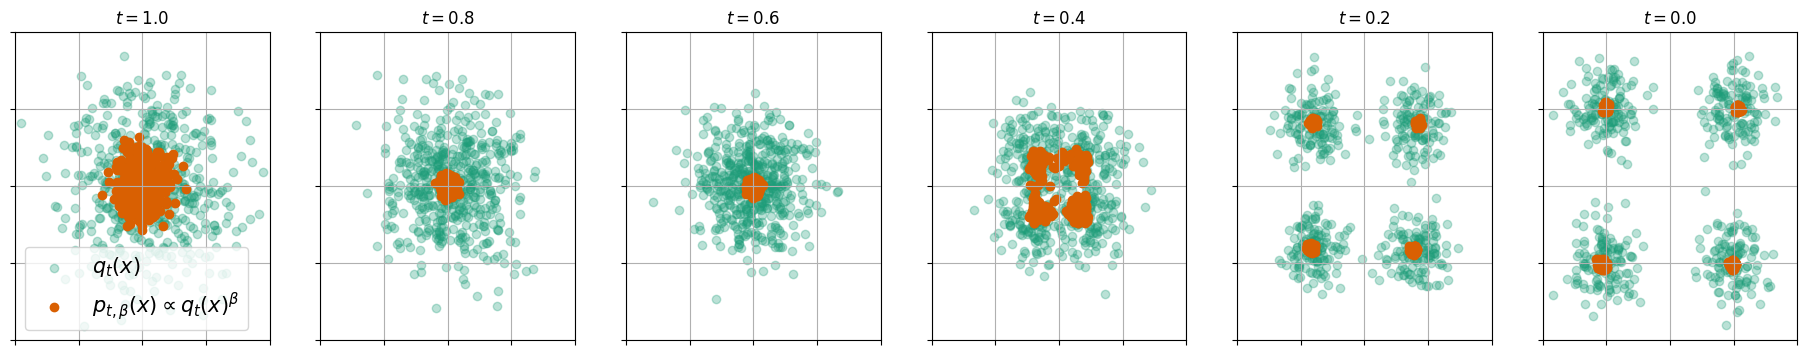

In [42]:
C1="#1D9D79"
C2="#756FB3"
C3="#D96002"

t_axis = np.linspace(0.0, 1.0, 6)
# t_axis = np.linspace(1e-2, 1.0, 6)

plt.figure(figsize=(23,4))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 4)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs), t)
  plt.scatter(x_t[:,0], x_t[:,1], label=r'$q_t(x)$', alpha=0.3, c=C1)
  if resample:
    ids = jnp.arange(bs)
  else:
    # ids = jax.random.choice(ikey[2], bs, (bs,), p=nn.softmax(w_gen[:,int(n*(t_axis[i])),0]))
    ids, next_u = sample_cat(bs, next_u, w_gen[:,int(n*(t_axis[i])),0])
  
  plt.scatter(x_gen[ids,int(n*(t_axis[i])),0], x_gen[ids,int(n*(t_axis[i])),1], c=C3, label=r'$p_{t,\beta}(x)\propto q_t(x)^\beta$')
  plt.xticks(np.linspace(-3,3,5),[])
  plt.yticks(np.linspace(-3,3,5),[])
  plt.title(rf'$t={t:1.1f}$')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)
    
plt.savefig('toy_annealing.pdf', bbox_inches='tight')

### Euler/Trapezoid/Full Integration Schemes of weights 
#### can probably ignore:  (I didn't see this helping much with the Clocks integrator)

In [16]:
@jax.jit
def sdlogqdx_fn(t,x):
  return state.apply_fn(state.params, t, x)

resample = True

integration = 'trapezoid' # 'full' 'euler'

scale_noise=  True
next_u = 0.5
dt = 1e-3
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
key, ikey = random.split(key, num=2)
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, x_t.shape[1]))/jnp.sqrt(inv_temp))
w_gen = jnp.zeros((bs,n+1,1))


if integration != 'euler':
  sdlogqdx = sdlogqdx_fn(t, x_gen[:,0,:])
        
for i in trange(n):
  key, *ikey = random.split(key, num=3)
  
  ''' step x ''' 
  if integration == 'euler':
    sdlogqdx = sdlogqdx_fn(t, x_gen[:,i,:])
  # else:  sdlogqdx is taken from previous iteration's evaluation of (t-dt, x_[t-dt])
  
  if not scale_noise:
    dx = dt*(-dlog_alphadt(t)*x_gen[:,i,:] + 2*inv_temp*gamma(t)*sdlogqdx) + jnp.sqrt(2*gamma(t)*jnp.exp(log_sigma(t))*dt)*random.normal(ikey[0], shape=(bs,2))
  else:
    dx = dt*(-dlog_alphadt(t)*x_gen[:,i,:] + (gamma(t)+inv_temp*gamma(t))*sdlogqdx) + jnp.sqrt(2*gamma(t)/inv_temp*jnp.exp(log_sigma(t))*dt)*random.normal(ikey[0], shape=(bs,2))
  x_gen = x_gen.at[:,i+1,:].set(x_gen[:,i,:] + dx)
  
  ''' calculate weights ''' 
  if integration == 'euler':
    dw = dt*((inv_temp-1)*2*dlog_alphadt(t) + 0.5*(inv_temp-1)*inv_temp*((jnp.sqrt(2*gamma(t)/jnp.exp(log_sigma(t)))*sdlogqdx)**2).sum(1, keepdims=True))
  else:
    if integration == 'trapezoid':
      dw = .5*dt*((inv_temp-1)*2*dlog_alphadt(t) + 0.5*(inv_temp-1)*inv_temp*((jnp.sqrt(2*gamma(t)/jnp.exp(log_sigma(t)))*sdlogqdx)**2).sum(1, keepdims=True))
    if i == n-1:
      # perform euler integration at final step
      dw = dw + .5*dw
    else:
      sdlogqdx = sdlogqdx_fn(t - dt, x_gen[:,i+1,:])
      if integration == 'trapezoid':
        ''' trapezoid = .5 euler dw + .5 next dw =  .5 w(t, x_t) dt +  .5 * w(t-dt, x_{t-dt}) dt'''
        dw += .5*dt*((inv_temp-1)*2*dlog_alphadt(t-dt) + 0.5*(inv_temp-1)*inv_temp*((jnp.sqrt(2*gamma(t-dt)/jnp.exp(log_sigma(t-dt)))*sdlogqdx)**2).sum(1, keepdims=True))
      elif integration == 'full':
        ''' full = w(t-dt, x_{t-dt}) dt '''
        dw = dt*((inv_temp-1)*2*dlog_alphadt(t-dt) + 0.5*(inv_temp-1)*inv_temp*((jnp.sqrt(2*gamma(t-dt)/jnp.exp(log_sigma(t-dt)))*sdlogqdx)**2).sum(1, keepdims=True))
  
  
  ''' increment weights '''      
  w_gen = w_gen.at[:,i+1,:].set(w_gen[:,i,:] + dw)
  
  ''' systematic only '''
  if resample:
    new_ids, _ = sample_cat_sys(bs, ikey[1], w_gen[:,i+1,0])
    x_gen = x_gen.at[:,i+1,:].set(x_gen[new_ids,i+1,:])
    w_gen = w_gen.at[:,i+1,:].set(0)
    
  ''' for full/trapezoid:  copy already-calculated scores @ (t-dt, x_{t-dt}) for next iteration'''  
  if integration !='euler':
    sdlogqdx = sdlogqdx[new_ids]
    
  t += -dt

100%|██████████| 1000/1000 [00:32<00:00, 30.35it/s]


## Alternative scheme

Let's use the following estimator
$$dx_\tau = d\tau\bigg(-f_{1-\tau}(x_\tau) + \frac{\beta+1}{2} g_{1-\tau}^2\nabla\log q_{1-\tau}(x_\tau)\bigg) + \frac{g_{1-\tau}}{\sqrt{\beta}}d\bar{W}_\tau\,,$$
$$dw_\tau = (\beta-1)\langle \nabla, f_{1-\tau}\rangle + \frac{1}{2}g_{1-\tau}^2(\beta-1)\beta\Vert\nabla \log q_{1-\tau}\Vert^2$$
where $\beta$ is the inverse temperature

In [17]:
@jax.jit
def sdlogqdx_fn(t,x):
  return state.apply_fn(state.params, t, x)

resample = True
inv_temp = 3
next_u = 0.5
dt = 1e-3
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
key, ikey = random.split(key, num=2)
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, x_t.shape[1]))/jnp.sqrt(inv_temp))
w_gen = jnp.zeros((bs,n+1,1))
for i in trange(n):
  key, *ikey = random.split(key, num=3)
  sdlogqdx = sdlogqdx_fn(t, x_gen[:,i,:])
  dx = dt*(-dlog_alphadt(t)*x_gen[:,i,:] + 2*(inv_temp+1)/2*gamma(t)*sdlogqdx) + jnp.sqrt(2*gamma(t)*jnp.exp(log_sigma(t))*dt/inv_temp)*random.normal(ikey[0], shape=(bs,2))
  x_gen = x_gen.at[:,i+1,:].set(x_gen[:,i,:] + dx)
  dw = dt*((inv_temp-1)*2*dlog_alphadt(t) + 0.5*(inv_temp-1)*inv_temp*((jnp.sqrt(2*gamma(t)/jnp.exp(log_sigma(t)))*sdlogqdx)**2).sum(1, keepdims=True))
  w_gen = w_gen.at[:,i+1,:].set(w_gen[:,i,:] + dw)
  if resample:
    # new_ids = jax.random.choice(ikey[1], bs, (bs,), p=nn.softmax(w_gen[:,i+1,0]))
    # new_ids, next_u = sample_cat(bs, next_u, w_gen[:,i+1,0])
    new_ids, _ = sample_cat_sys(bs, ikey[1], w_gen[:,i+1,0])
    x_gen = x_gen.at[:,i+1,:].set(x_gen[new_ids,i+1,:])
    w_gen = w_gen.at[:,i+1,:].set(0)
  t += -dt

100%|██████████| 1000/1000 [00:23<00:00, 43.08it/s]


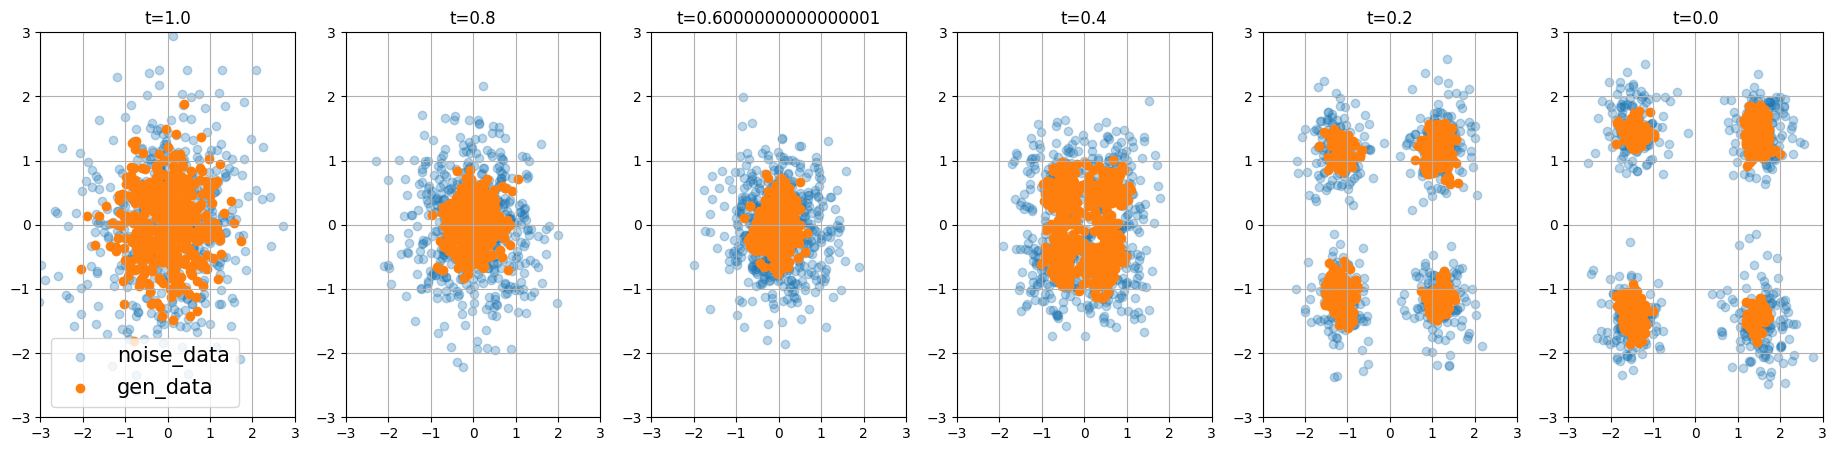

In [18]:
t_axis = np.linspace(0.0, 1.0, 6)
# t_axis = np.linspace(1e-2, 1.0, 6)

plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 4)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data', alpha=0.3)
  if resample:
    ids = jnp.arange(bs)
  else:
    # ids = jax.random.choice(ikey[2], bs, (bs,), p=nn.softmax(w_gen[:,int(n*(t_axis[i])),0]))
    ids, next_u = sample_cat(bs, next_u, w_gen[:,int(n*(t_axis[i])),0])
  plt.scatter(x_gen[ids,int(n*(t_axis[i])),0], x_gen[ids,int(n*(t_axis[i])),1], label='gen_data')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)